In [1]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from Utils import *
from Visualization_Utils import *

device = torch.device("cuda:0")

In [2]:
path_to_saved_models = "saved_models"
path_to_test_results = "test_results"
path_to_tsne_figures = "tsne_figures"

# loading the test data
test_data = np.load('/home/ismail/Dev/data_2013/EEG_Fpz-Cz/traindata_smote/trainData__SMOTE_all_10s_f0_TEST.npz')

# Test set accuracy plots

In this section, we will compare the performance of each model against a test set sample.

The following saved values are the recorded average accuracies for all folds per epoch.
These values have been recorded while training the models.

We will discuss the results in 3 cases:
- Without any sampling
- With undersampling using RUS
- With oversampling using SMOTE

#### Without sampling

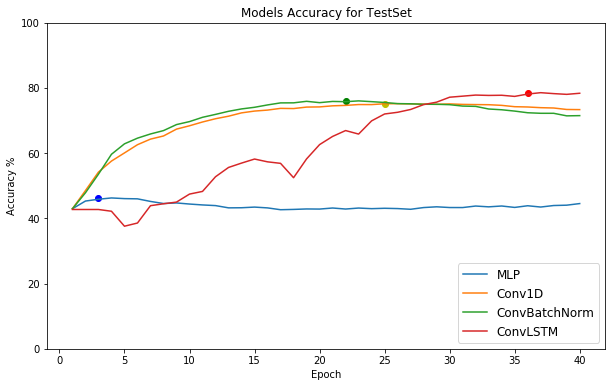

In [3]:
plot_compare_curve(path_to_test_results, smapling=0)

<img src="images/no_sampling.png">

#### With RandomUnderSampling

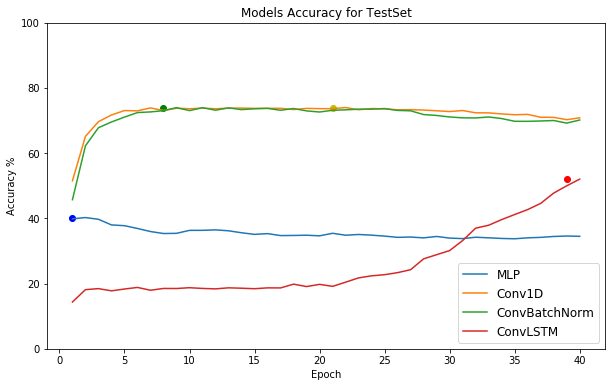

In [4]:
plot_compare_curve(path_to_test_results, smapling=2)

The result shows that MLP achieves the worst performance and this is expected due to its basic structure that consists of only dense layers, so it wasn't able to recognize the temporal dependencies between data.

On the other side, end-to-end 1D CNN achieved stable performance and was able to reach the best accuracy at an early epoch. This is 

<img src="images/under_sampling.png">

#### With SMOTE oversampling

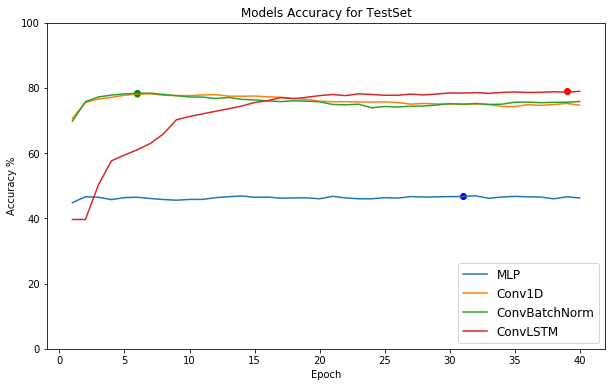

In [5]:
plot_compare_curve(path_to_test_results, smapling=1)

<img src="images/over_sampling0.png">

# T-SNE visualization

In this section, we aim to visualize the output of the last layer for each model to check how well it classifies the test set data.

But as the dataset is in high dimension, so we used T-SNE to plot the data in 2D plane.

We will do so for MLP, 1DCNN, and ConvLSTM.

In [6]:
X_test = test_data["x"].astype(np.float64)
y_test = test_data["y"]

### Plotting the whole test data before any classification

In [7]:
X_tsne = TSNE(n_components=2).fit_transform(X_test.reshape(X_test.shape[0],-1))

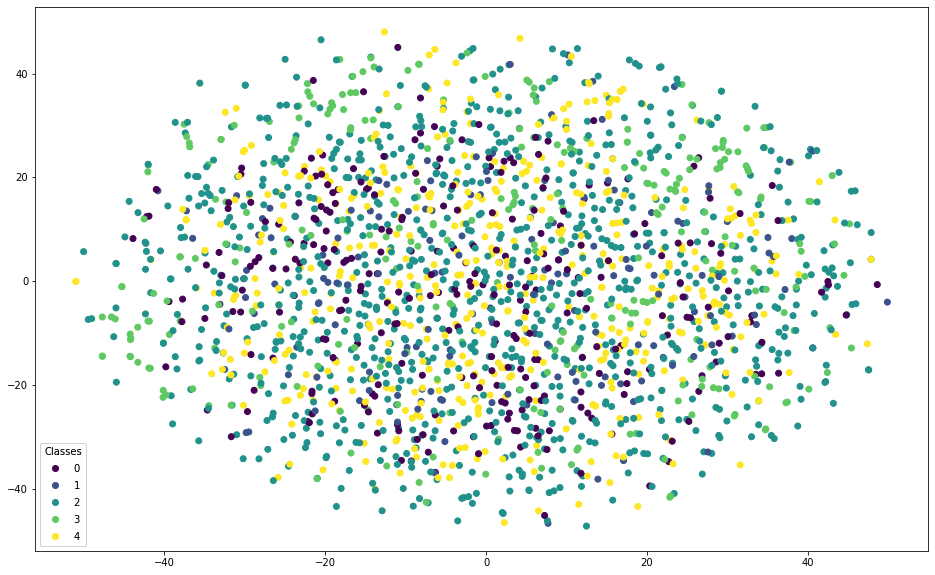

In [8]:
fig, ax = plt.subplots(figsize=(16, 10))

scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_test.squeeze())
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
plt.show()

### Plotting output of  MLP 

In [9]:
mlp_net = torch.load(os.path.join(path_to_saved_models,"MLP_best.pt"),map_location='cuda:0')

In [10]:
batch_size = 1
bi_dir = False
test_x, test_y = X_test, y_test
mlp_net.eval()
mlp_output = torch.zeros((test_x.shape[0], 128))
with torch.no_grad():

    for i in range(0, len(test_x)):#, batch_size):
        test_x_batch = test_x[i:i + batch_size]
        test_y_batch = test_y[i:i + batch_size]

        test_x_batch = torch.from_numpy(test_x_batch).to(device)
        test_y_batch = torch.from_numpy(test_y_batch).view(-1).to(device)

        m_input = test_x_batch
        scores, y = mlp_net(m_input.float())
        mlp_output[i,:] = y

In [31]:
mlp_tsne = TSNE(n_components=2,random_state=1).fit_transform((Variable(mlp_output).data).cpu().numpy().reshape(X_test.shape[0],-1).astype(np.float64))

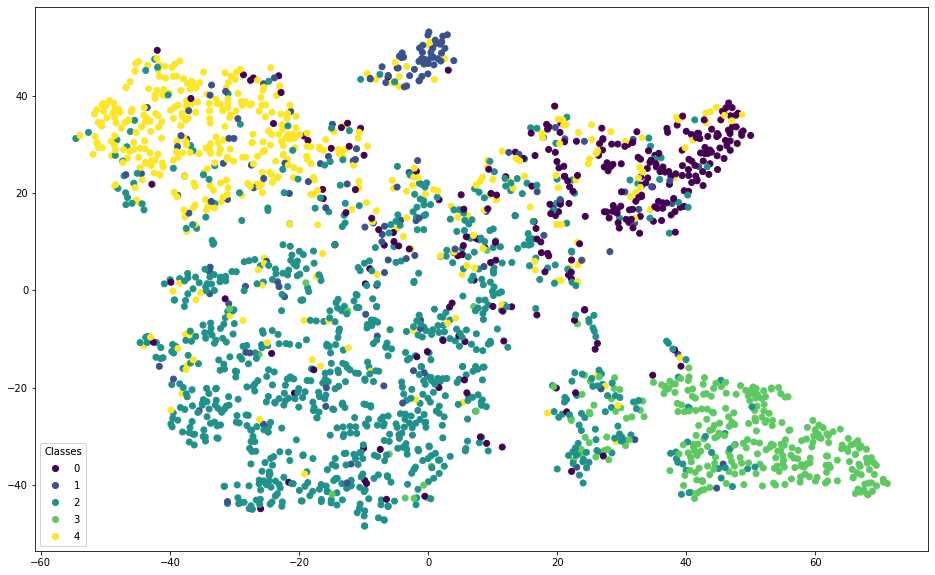

In [32]:
fig, ax = plt.subplots(figsize=(16, 10))

scatter = ax.scatter(mlp_tsne[:, 0], mlp_tsne[:, 1], c=y_test.squeeze())
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
plt.show()

### Plotting output of 1D CNN

In [35]:
conv_net = torch.load(os.path.join(path_to_saved_models,"ConvSimple_best.pt"),map_location='cuda:0')

In [36]:
batch_size = 1
bi_dir = False
test_x, test_y = X_test, y_test
conv_net.eval()
conv_output = torch.zeros((test_x.shape[0], 128))
with torch.no_grad():
    
    for i in range(0, len(test_x)):
        test_x_batch = test_x[i:i + batch_size]
        test_y_batch = test_y[i:i + batch_size]

        test_x_batch = torch.from_numpy(test_x_batch).to(device)
        test_y_batch = torch.from_numpy(test_y_batch).view(-1).to(device)

        m_input = test_x_batch
        line2, lin1 = conv_net(m_input.float())
        conv_output[i,:] = lin1


In [37]:
conv_tsne = TSNE(n_components=2, random_state=1).fit_transform((Variable(conv_output).data).cpu().numpy().reshape(X_test.shape[0],-1).astype(np.float64))

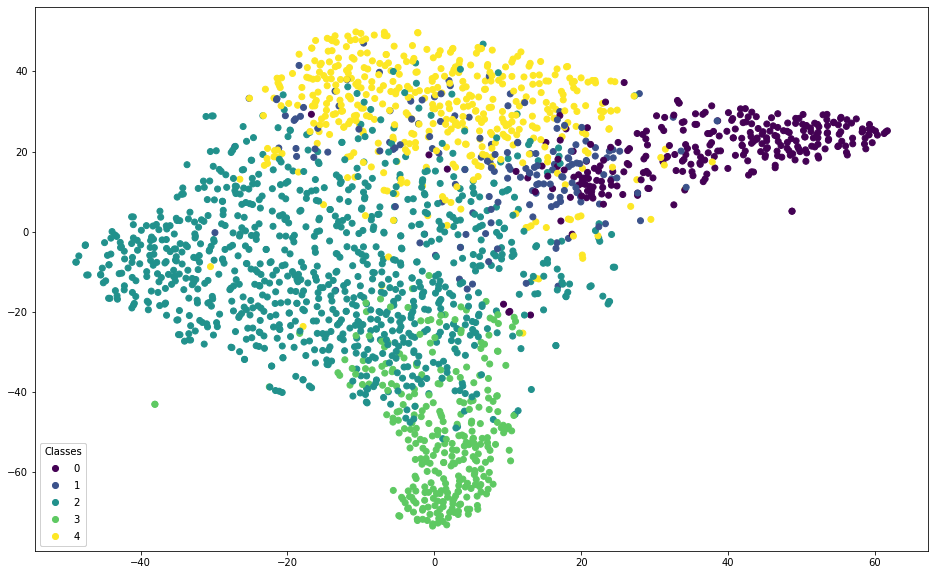

In [38]:
fig, ax = plt.subplots(figsize=(16, 10))

scatter = ax.scatter(conv_tsne[:, 0], conv_tsne[:, 1], c=y_test.squeeze())
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
plt.show()

### Plotting output of ConvLSTM

In [39]:
net = torch.load(os.path.join(path_to_saved_models,"ConvLSTM_best.pt"), map_location='cuda:0')

In [40]:
batch_size = 1
bi_dir = False
test_x, test_y = X_test, y_test
net.eval()
conv_outputs = torch.zeros((test_x.shape[0], 256))
with torch.no_grad():
    correct = 0
    total = 0
    num_lstm_layers = 1
    hidden_dim_of_lstm1 = 256
    count =0 
    for i in range(0, len(test_x)):
        test_x_batch = test_x[i:i + batch_size]
        test_y_batch = test_y[i:i + batch_size]

        test_x_batch = torch.from_numpy(test_x_batch).to(device)
        test_y_batch = torch.from_numpy(test_y_batch).view(-1).to(device)

        # initial hidden states
        h = torch.zeros((1 + int(bi_dir)) * num_lstm_layers, 1,
                        hidden_dim_of_lstm1)
        c = torch.zeros((1 + int(bi_dir)) * num_lstm_layers, 1, hidden_dim_of_lstm1)

        h = h.to(device)
        c = c.to(device)

        m_input = test_x_batch
        outputs, lstm_out = net(m_input.float(), h, c)
#         print(lstm_out.shape)
        conv_outputs[i,:] = lstm_out.squeeze()

In [41]:
convlstm_tsne = TSNE(n_components=2, random_state=1).fit_transform((Variable(conv_outputs).data).cpu().numpy().reshape(X_test.shape[0],-1).astype(np.float64))

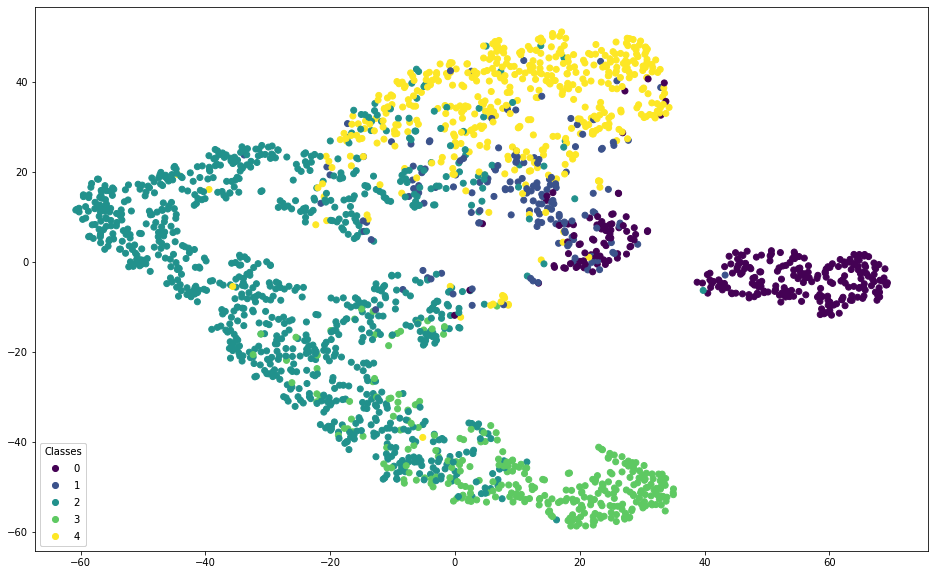

In [42]:
fig, ax = plt.subplots(figsize=(16, 10))

scatter = ax.scatter(convlstm_tsne[:, 0], convlstm_tsne[:, 1], c=y_test.squeeze())
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
plt.show()

In [21]:
conv_net = torch.load(os.path.join(path_to_saved_models,"ConvSimple_X_TSNE.pt"),map_location='cuda:0')
conv_net_y = torch.load(os.path.join(path_to_saved_models,"ConvSimple_Y_TSNE.pt"),map_location='cuda:0')

In [22]:
print(conv_net[0].shape)
print(conv_net_y[0].shape)

torch.Size([2048, 128])
torch.Size([2048])


In [23]:
conv_tsne = TSNE(n_components=2,random_state=1).fit_transform((Variable(conv_net[0]).data).cpu().numpy().reshape(2048,-1).astype(np.float64))

In [24]:
yy = Variable(conv_net_y[0]).data.cpu().numpy().astype(np.float64)

In [25]:
print(conv_tsne.shape)
print(yy.shape)

(2048, 2)
(2048,)


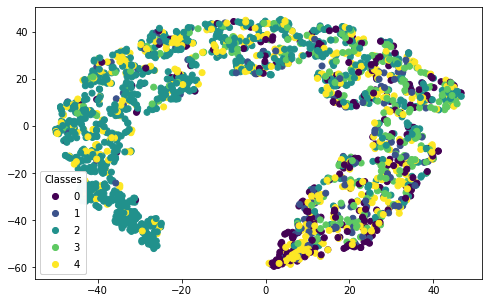

In [26]:
fig, ax = plt.subplots(figsize=(8, 5))

scatter = ax.scatter(conv_tsne[:, 0], conv_tsne[:, 1], c=yy)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
plt.show()

In [27]:
conv_tsne = TSNE(n_components=2).fit_transform((Variable(conv_net[1]).data).cpu().numpy().reshape(2048,-1).astype(np.float64))

In [28]:
yy = Variable(conv_net_y[1]).data.cpu().numpy().astype(np.float64)

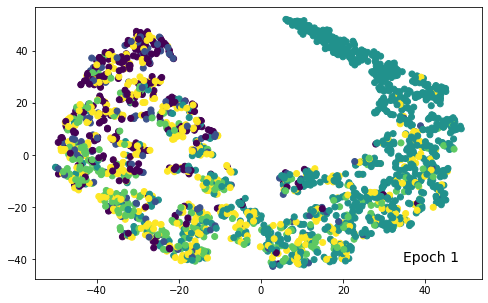

In [29]:
fig, ax = plt.subplots(figsize=(8, 5))

scatter = ax.scatter(conv_tsne[:, 0], conv_tsne[:, 1], c=yy)
ax.text(0.95, 0.05, "Epoch 1", transform=ax.transAxes, fontsize=14,
        verticalalignment='bottom', horizontalalignment='right')
plt.show()

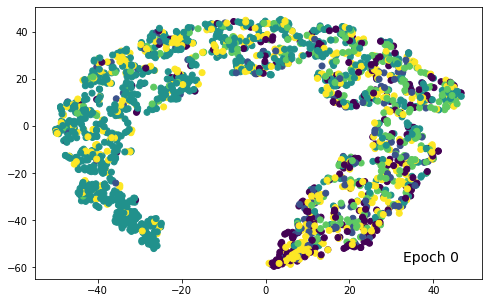

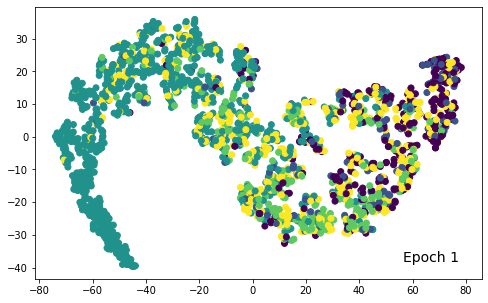

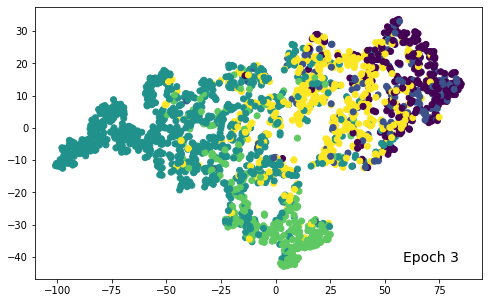

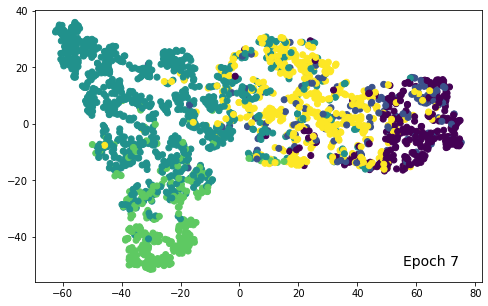

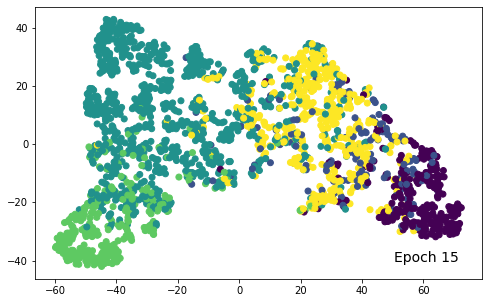

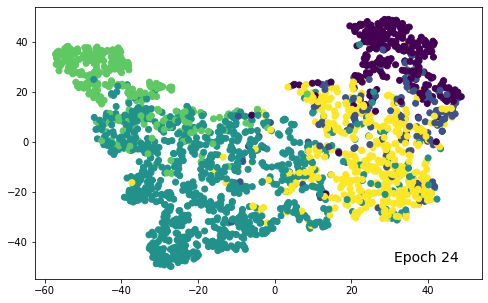

In [30]:
for k in [0, 1, 3, 7, 15, 24]:
    conv_tsne = TSNE(n_components=2, random_state=1).fit_transform((Variable(conv_net[k]).data).cpu().numpy().reshape(2048,-1).astype(np.float64))
    yy = Variable(conv_net_y[k]).data.cpu().numpy().astype(np.float64)
    fig, ax = plt.subplots(figsize=(8, 5))

    scatter = ax.scatter(conv_tsne[:, 0], conv_tsne[:, 1], c=yy)
    ax.text(0.95, 0.05, "Epoch "+str(k), transform=ax.transAxes, fontsize=14,
        verticalalignment='bottom', horizontalalignment='right')
#     legend1 = ax.legend(*scatter.legend_elements(),
#                         loc="lower left", title="Classes")
#     ax.add_artist(legend1)
    plt.savefig(os.path.join(path_to_tsne_figures, str(k)+".png"))